# XGBoost miRNA
Runs XGBoostClassifer on miRNA data.  

Three datasets are analyzed using the XGBoost classifier:
* Sham and infeceted mice from all weeks; i.e., 8 week and 16 week datasets are merged.
* Sham and infected mice at 8 weeks.
* Sham and infected mice at 16 weeks.

In each dataset, there is a flag (named ‘infected’) that marks whether the mice came from the infected group or the sham group.  
XGBoost's variable importance and SHAP values are then used to determine which miRNA variable was most important in each cohort dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

In [4]:
! python --version

Python 3.11.4


In [5]:
print('xgboost version', xgb.__version__)
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

xgboost version 1.7.6
sklearn version 1.3.0
shap version 0.42.1


### helper functions

In [6]:
def make_study_df(miRNA_df, infected_str='tf_', cohort_str=None):
    df = miRNA_df.copy()

    # subset to cohort
    if cohort_str:
        df = df[df.cohort.str.endswith(cohort_str)]
    
    # add column to identify infected mice
    df['infected'] = np.where(df.cohort.str.startswith(infected_str), 1, 0)

    # drop cohort, number, and name data
    df = df.iloc[:, 4:] 
    
    # shuffle data
    df = df.sample(frac=1, random_state=1989)

    # shuffle columns
    cols = list(df.columns)
    random.shuffle(cols)
    df = df[cols]
        
    return df

## load miRNA data

In [7]:
miRNA_df = pd.read_excel('../data/transposed_Tf_miRNA.xlsx')

## create dataframes and X, y datasets

In [8]:
df_all_weeks = make_study_df(miRNA_df)
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks')

In [9]:
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']

### compute XGBoost models

In [10]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
    #"nfold": 5,
    #"num_boost_round": 100, 
    #"early_stopping_rounds": 10, 
    #"metrics": "accuracy"
}   

In [11]:
model_all_weeks = xgb.XGBClassifier(**params).fit(X_all_weeks, y_all_weeks)
model_8_weeks = xgb.XGBClassifier(**params).fit(X_8_weeks, y_8_weeks)
model_16_weeks = xgb.XGBClassifier(**params).fit(X_16_weeks, y_16_weeks)

### compute SHAP values (used for explainablity)

In [12]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

In [13]:
explainer_all_weeks = shap.TreeExplainer(model_all_weeks, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

explainer_8_weeks = shap.TreeExplainer(model_8_weeks, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.TreeExplainer(model_16_weeks, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

---

## Bar plots of feature importance
The XGBoost feature importance differs from the SHAP feature importance. They are measuring differently. See this [article](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for details.

## bar plots for all weeks

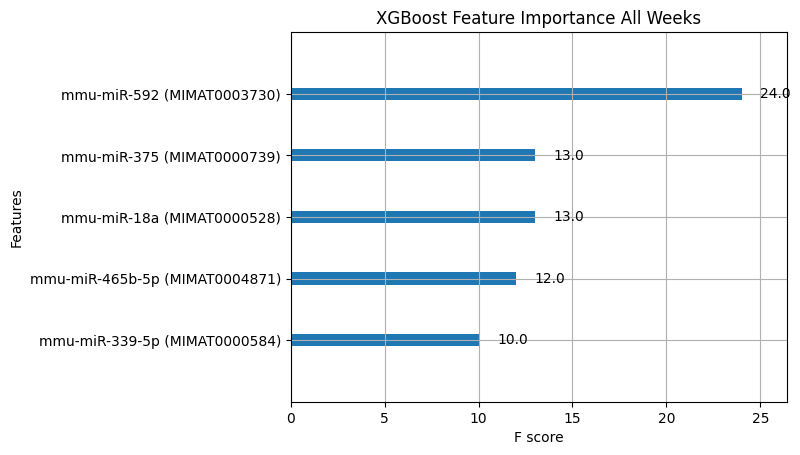

<Figure size 400x400 with 0 Axes>

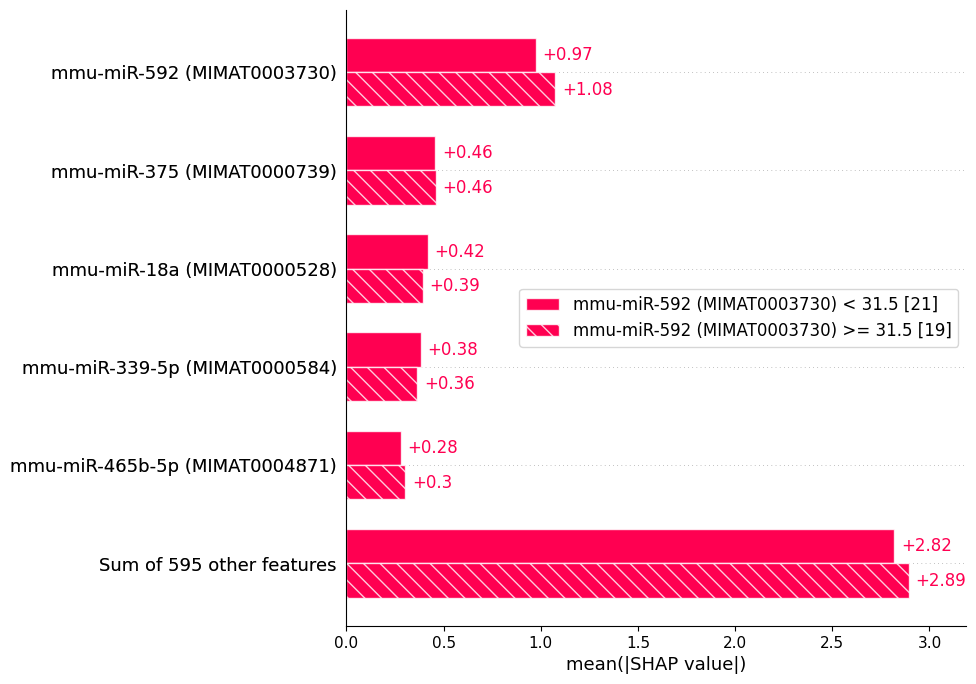

In [14]:
xgb.plot_importance(model_all_weeks, max_num_features=5, title='XGBoost Feature Importance All Weeks')
plt.figure(figsize = (4, 4))
plt.show()

# fig = plt.figure()
shap.plots.bar(shap_values_all_weeks.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

## bar plots for 8 weeks

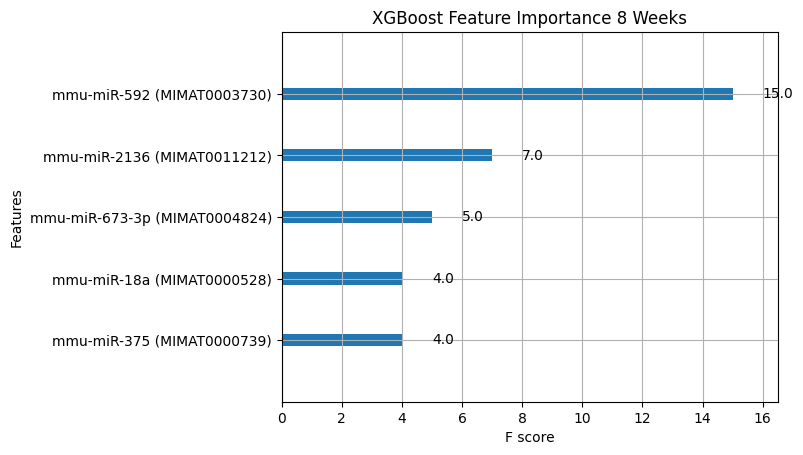

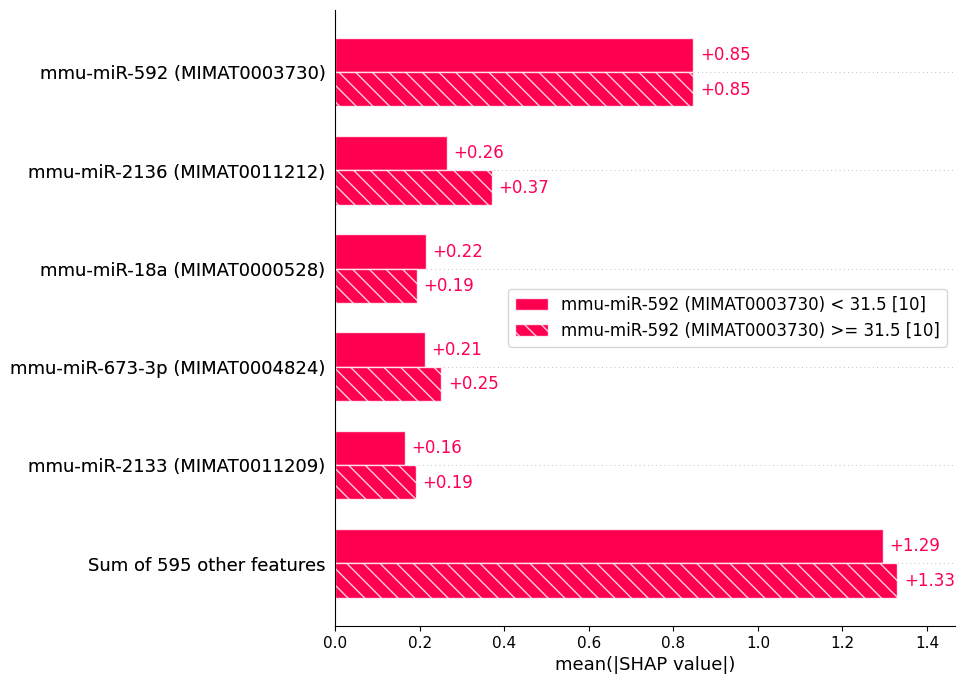

In [15]:
xgb.plot_importance(model_8_weeks, max_num_features=5, title='XGBoost Feature Importance 8 Weeks')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_8_weeks.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

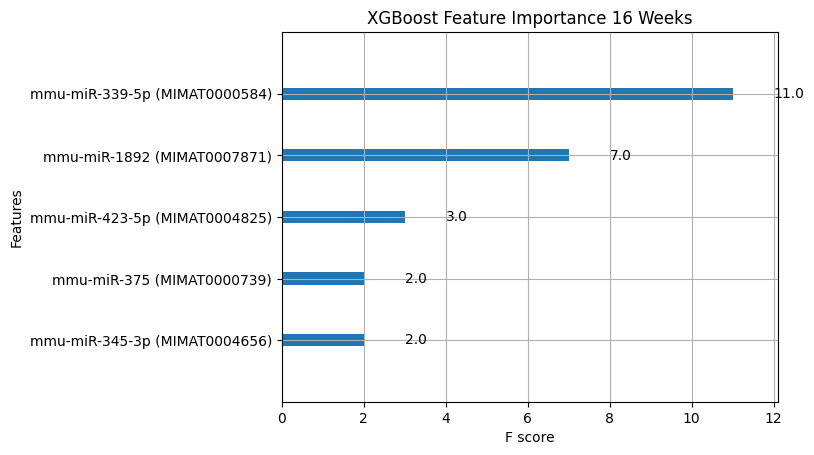

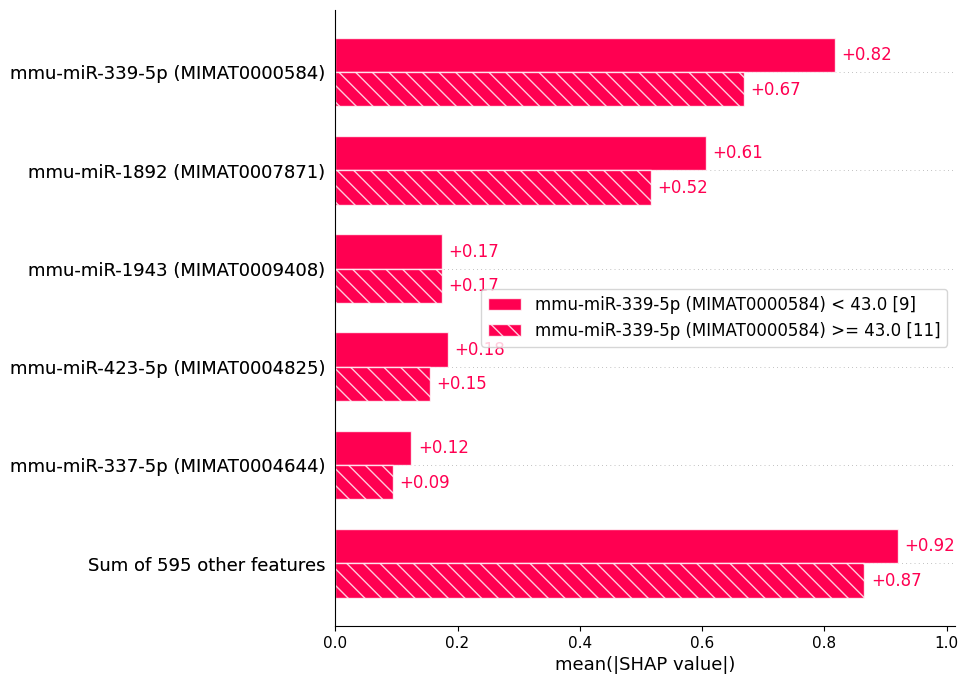

In [16]:
xgb.plot_importance(model_16_weeks, max_num_features=5, title='XGBoost Feature Importance 16 Weeks')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_16_weeks.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

## SHAP summary plots

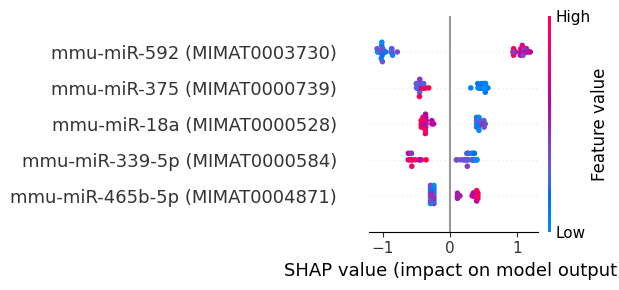

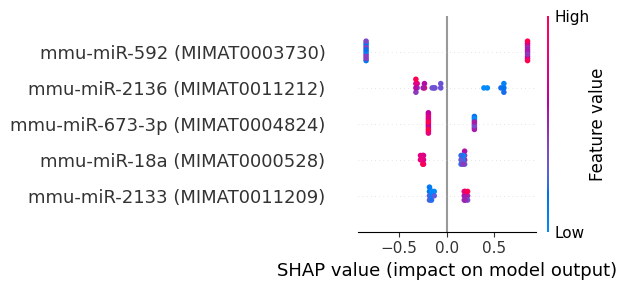

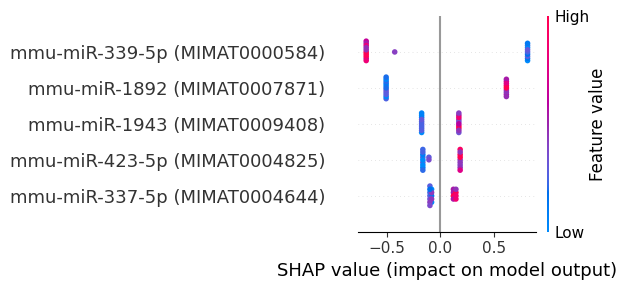

In [17]:
shap.summary_plot(shap_values_all_weeks, X_all_weeks, plot_size=(6, 3), max_display=5)
shap.summary_plot(shap_values_8_weeks, X_8_weeks, plot_size=(6, 3), max_display=5)
shap.summary_plot(shap_values_16_weeks, X_16_weeks, plot_size=(6, 3), max_display=5)

## SHAP heatmaps

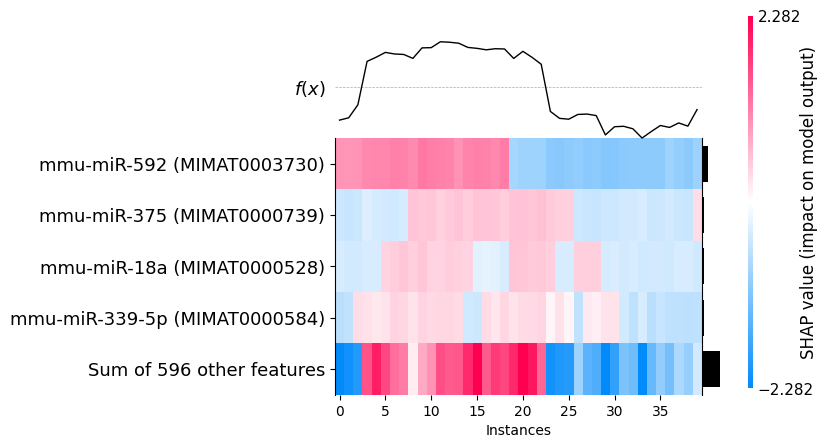

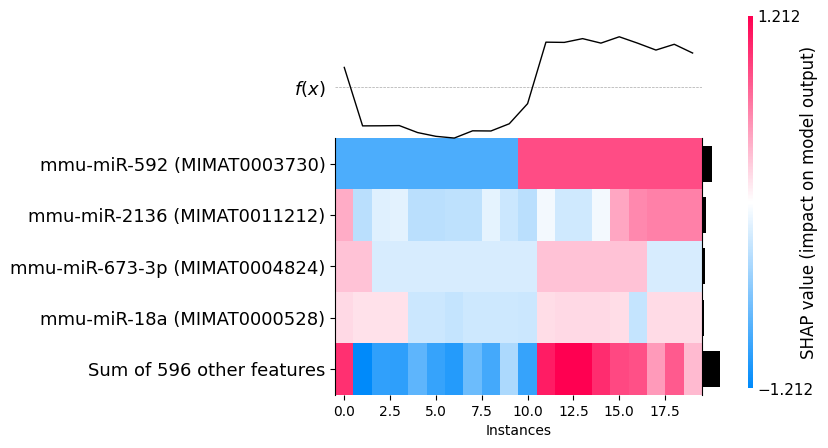

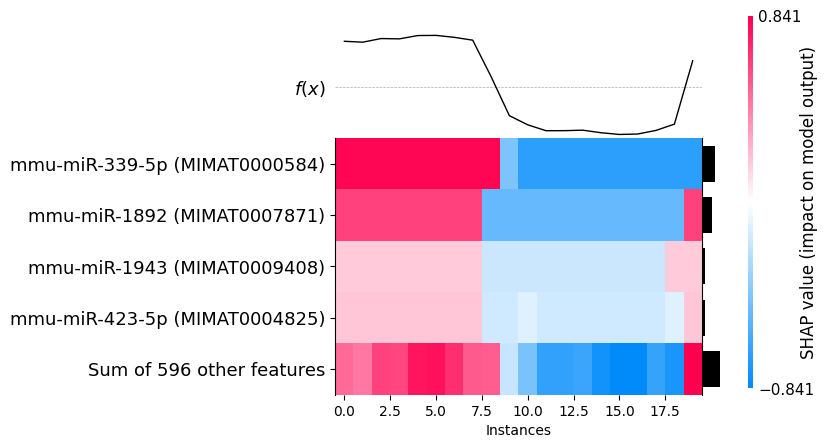

In [18]:
shap.plots.heatmap(shap_values_all_weeks, plot_width=6, max_display=5)
shap.plots.heatmap(shap_values_8_weeks, plot_width=6, max_display=5)
shap.plots.heatmap(shap_values_16_weeks, plot_width=6, max_display=5)

## SHAP dependence plots

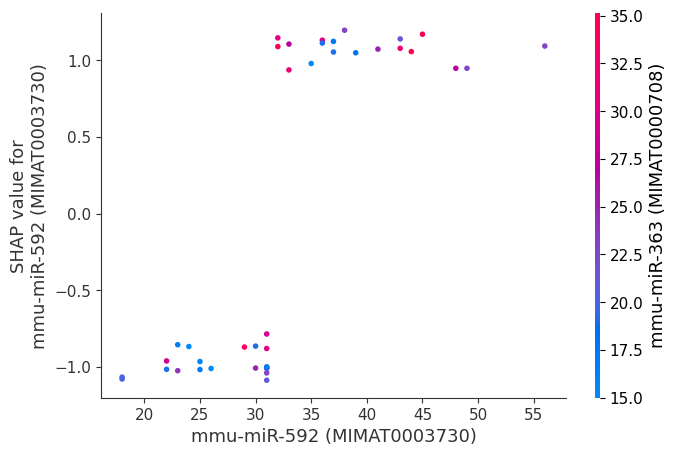

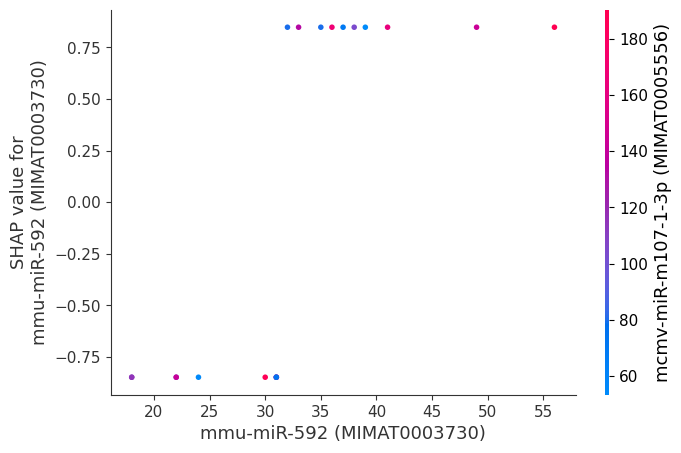

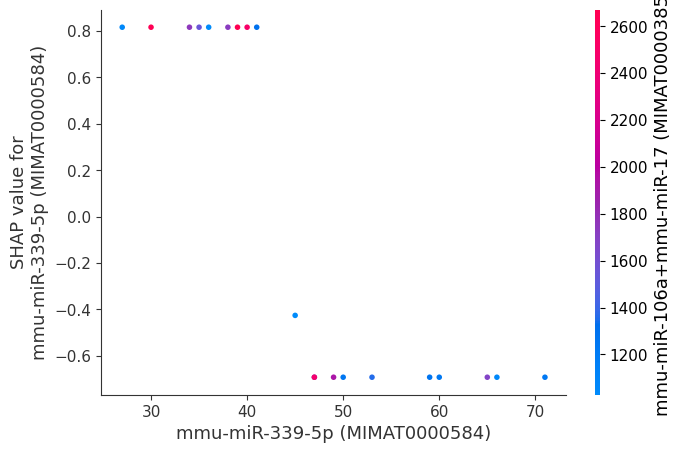

In [19]:
shap.dependence_plot("rank(0)", shap_values_all_weeks.values, X_all_weeks, display_features=X_all_weeks)
shap.dependence_plot("rank(0)", shap_values_8_weeks.values, X_8_weeks, display_features=X_8_weeks)
shap.dependence_plot("rank(0)", shap_values_16_weeks.values, X_16_weeks, display_features=X_16_weeks)

---

## experiment with grid search for best params

In [20]:
cv_params = {
    'n_estimators': range(1,300),              # default = 100
    'max_depth': range(1, 100),                 # default = 3
    'learning_rate': [.1, .3, .4, .5, .6],     # default = .3
    'colsample_bytree': [.6, .7, .8, .9, 1],   # default = 1,
    'booster':['gbtree']
}

In [21]:
grid_search = GridSearchCV(xgb.XGBRegressor(), cv_params, n_jobs=10, scoring='neg_mean_absolute_error', refit=True)

In [22]:
# # this takes around 1 day to run, so saving the results
# grid_search.fit(X_8_weeks, y_8_weeks)
# grid_search.best_params_

# # results
# {'booster': 'gbtree',
#  'colsample_bytree': 0.7,
#  'learning_rate': 0.1,
#  'max_depth': 2,
#  'n_estimators': 1}

In [23]:
grid_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 2,
    'n_estimators': 1
}
model_grid_all = xgb.XGBClassifier(**grid_params).fit(X_all_weeks, y_all_weeks)
model_grid_8 = xgb.XGBClassifier(**grid_params).fit(X_8_weeks, y_8_weeks)
model_grid_16 = xgb.XGBClassifier(**grid_params).fit(X_16_weeks, y_16_weeks)

In [24]:
explainer_grid_all = shap.TreeExplainer(model_grid_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_grid_all = explainer_grid_all(X_all_weeks)

explainer_grid_8 = shap.TreeExplainer(model_grid_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_grid_8 = explainer_grid_8(X_8_weeks)

explainer_grid_16 = shap.TreeExplainer(model_grid_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_grid_16 = explainer_grid_16(X_16_weeks)

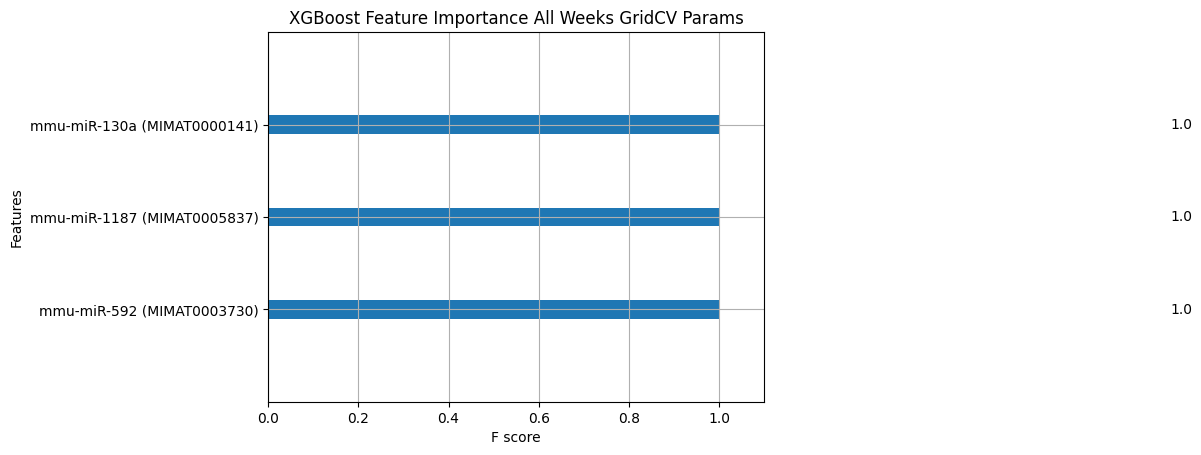

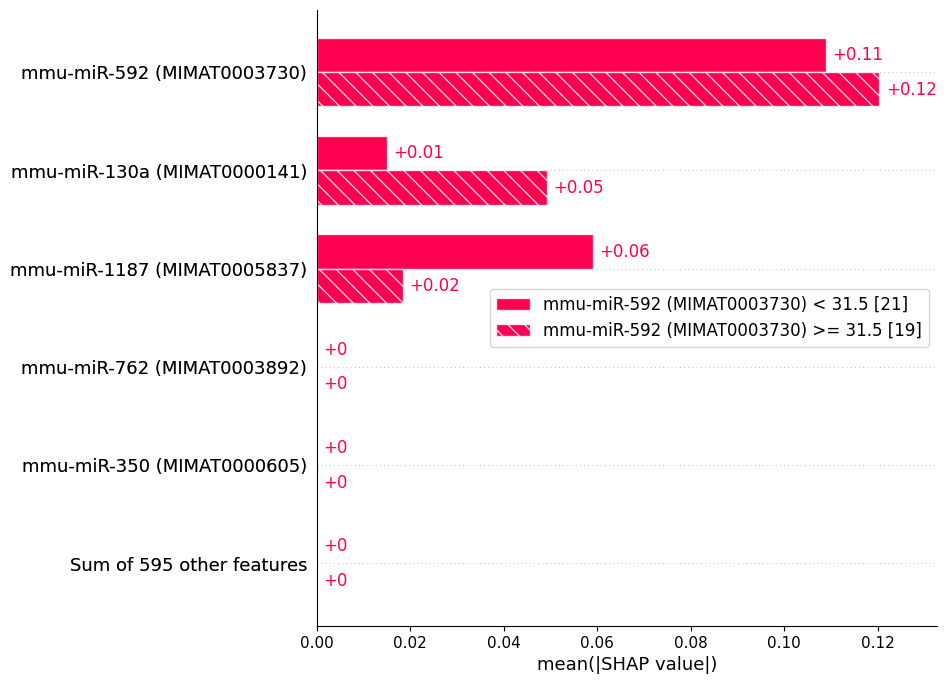

In [25]:
xgb.plot_importance(model_grid_all, max_num_features=5, title='XGBoost Feature Importance All Weeks GridCV Params')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_grid_all.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

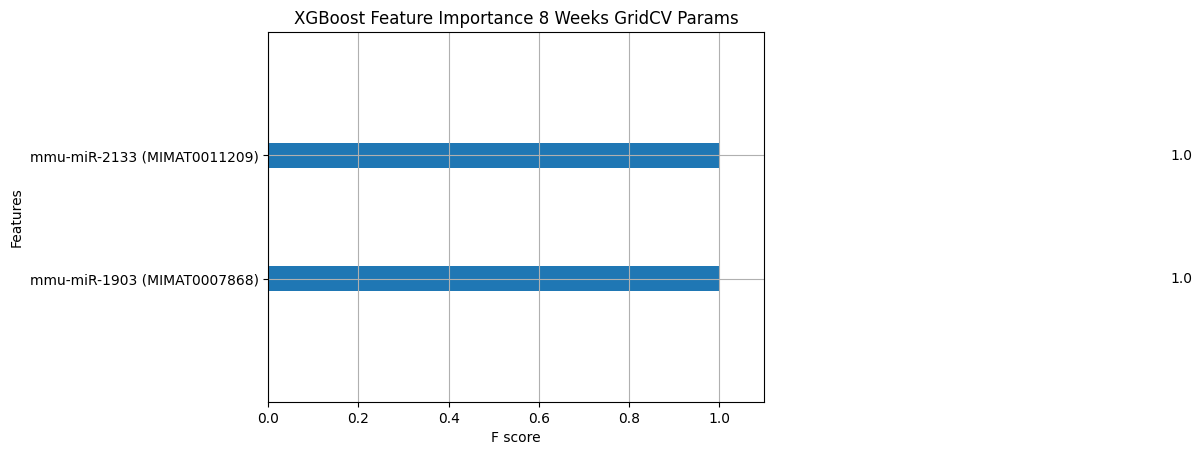

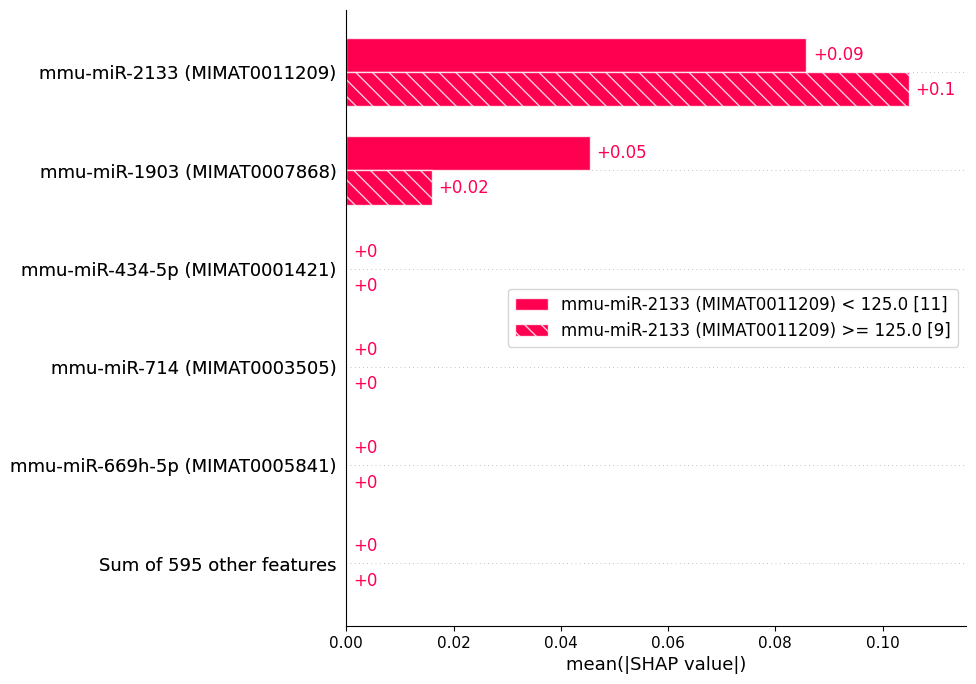

In [26]:
xgb.plot_importance(model_grid_8, max_num_features=5, title='XGBoost Feature Importance 8 Weeks GridCV Params')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_grid_8.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

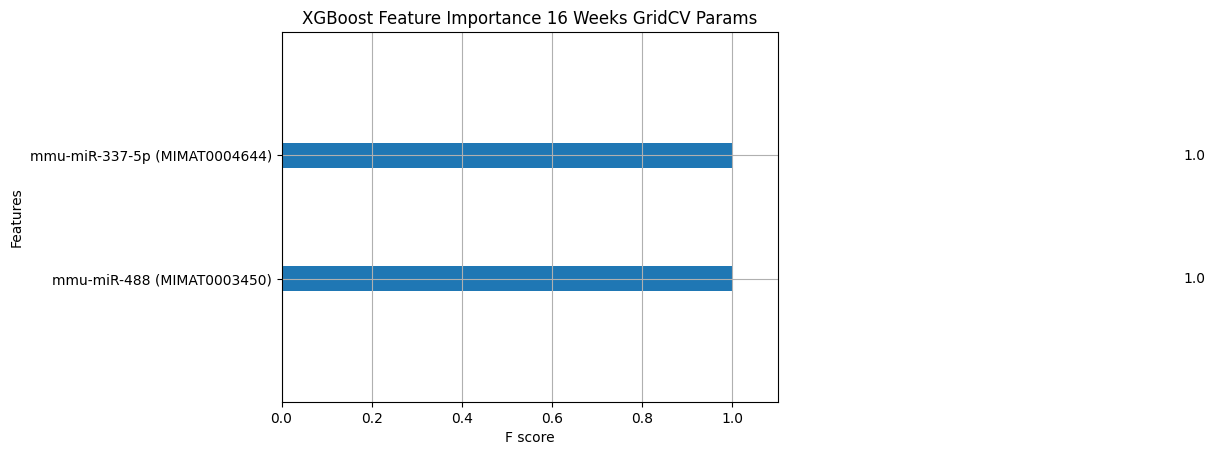

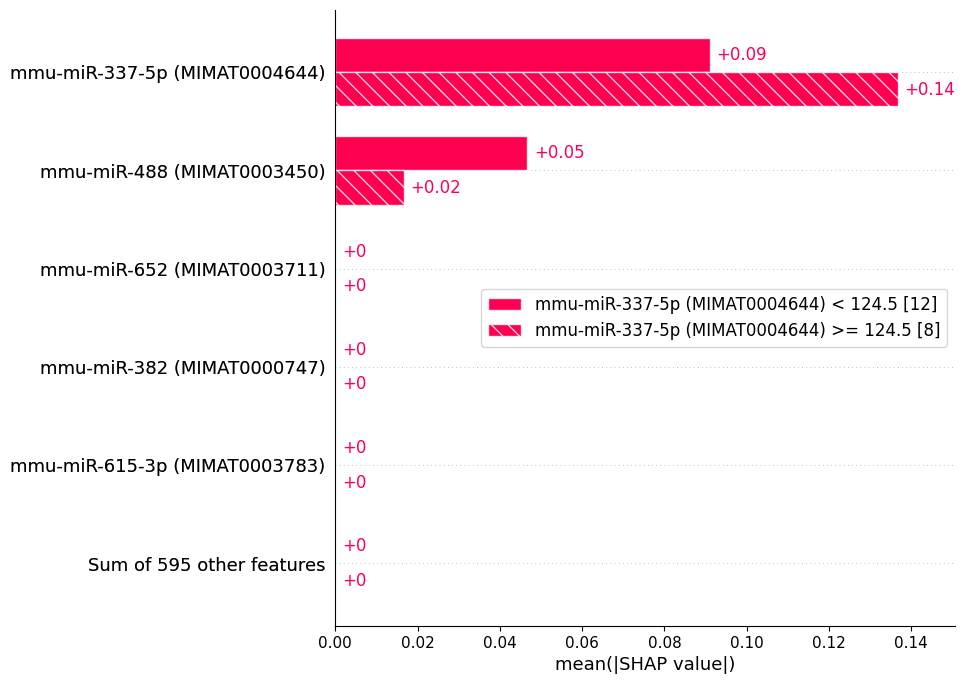

In [27]:
xgb.plot_importance(model_grid_16, max_num_features=5, title='XGBoost Feature Importance 16 Weeks GridCV Params')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_grid_16.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

----

### expirment with increased extimators and tree depth

In [28]:
increased_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 600,
    'n_estimators': 600,
    'random_state': 42
}
model_increased_all = xgb.XGBClassifier(**increased_params).fit(X_all_weeks, y_all_weeks)
model_increased_8 = xgb.XGBClassifier(**increased_params).fit(X_8_weeks, y_8_weeks)
model_increased_16 = xgb.XGBClassifier(**increased_params).fit(X_16_weeks, y_16_weeks)

In [29]:
explainer_increased_all = shap.TreeExplainer(model_increased_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_increased_all = explainer_increased_all(X_all_weeks)

explainer_increased_8 = shap.TreeExplainer(model_increased_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_increased_8 = explainer_increased_8(X_8_weeks)

explainer_increased_16 = shap.TreeExplainer(model_increased_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_increased_16 = explainer_increased_16(X_16_weeks)

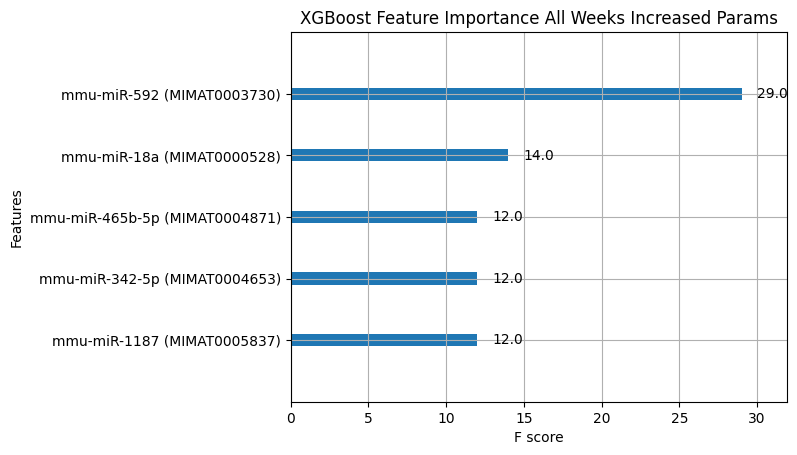

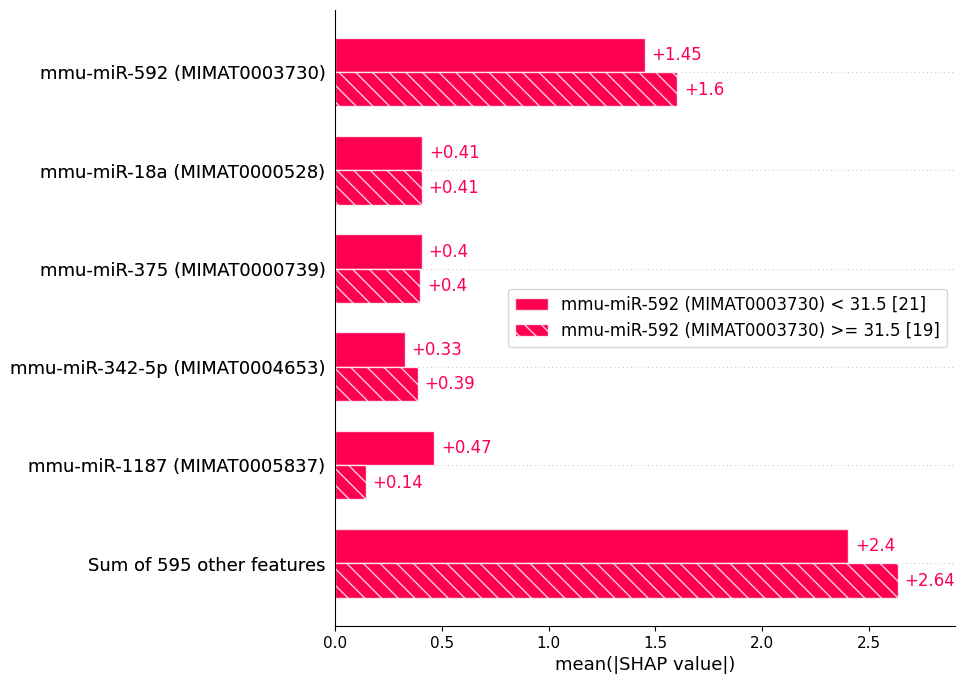

In [30]:
xgb.plot_importance(model_increased_all, max_num_features=5, title='XGBoost Feature Importance All Weeks Increased Params')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_increased_all.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

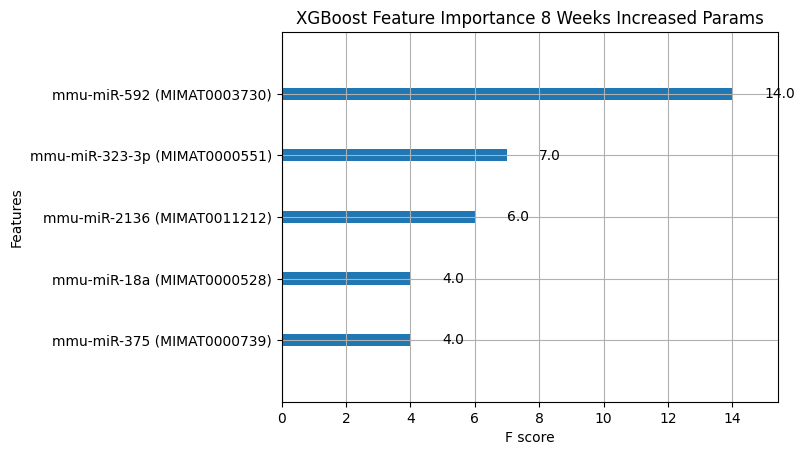

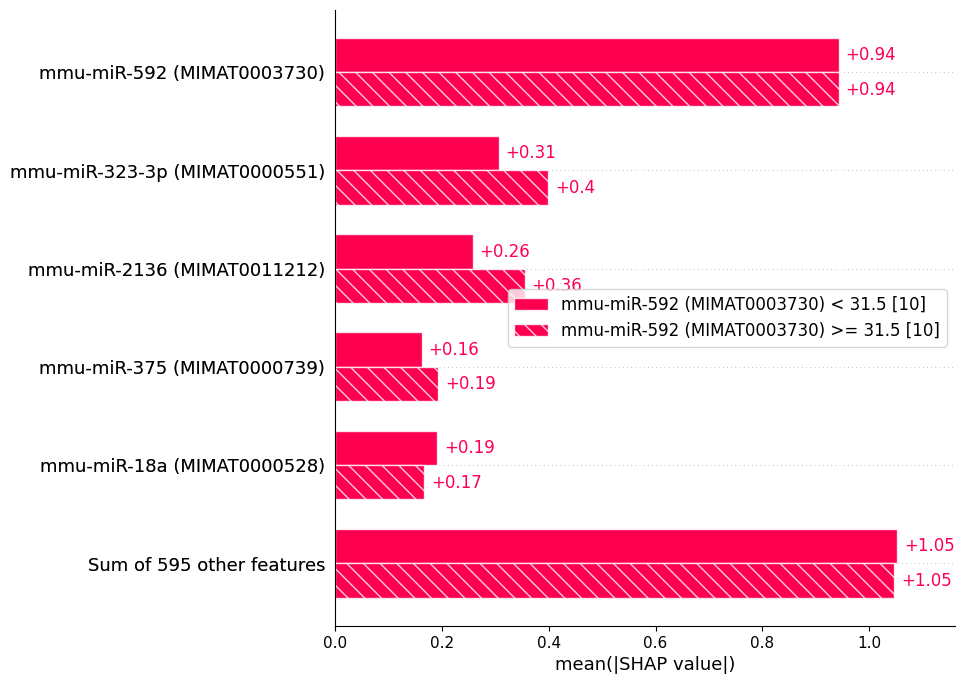

In [31]:
xgb.plot_importance(model_increased_8, max_num_features=5, title='XGBoost Feature Importance 8 Weeks Increased Params')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_increased_8.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

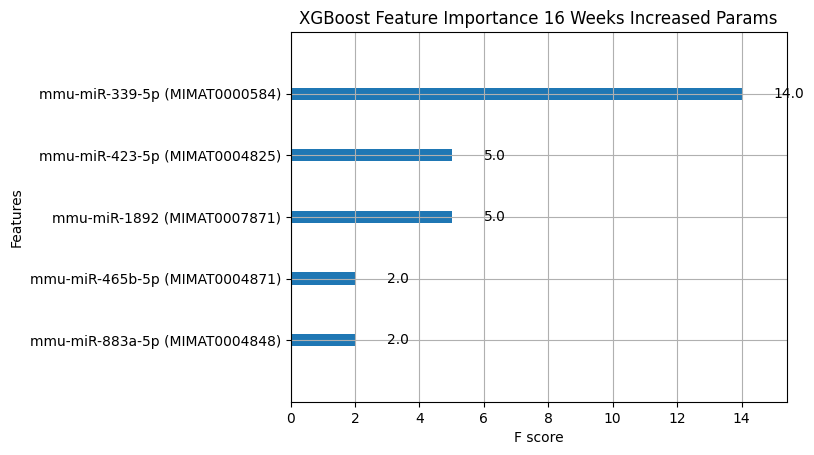

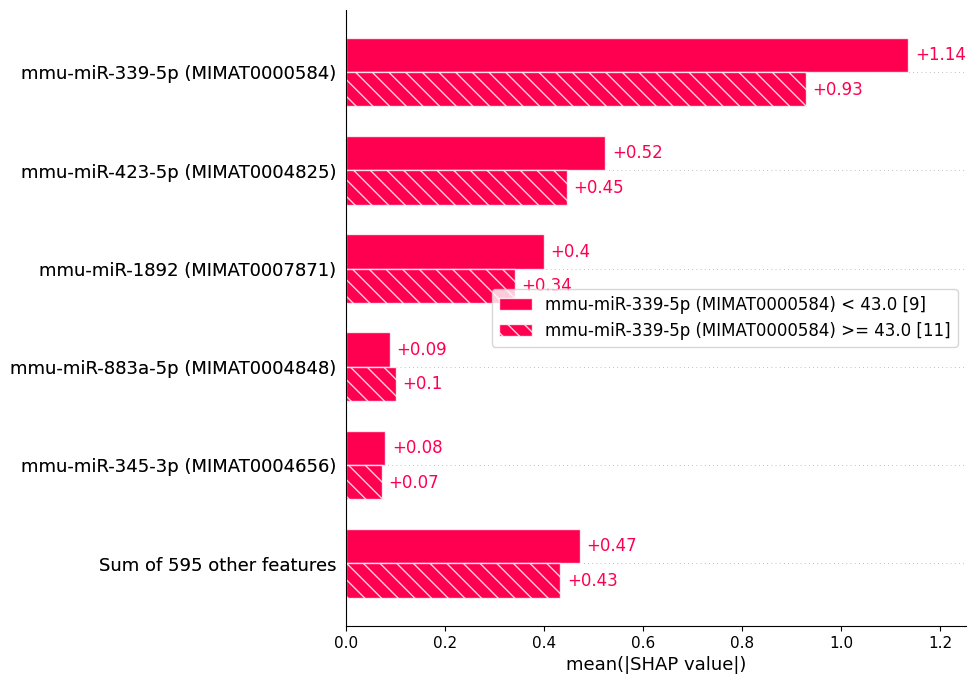

In [32]:
xgb.plot_importance(model_increased_16, max_num_features=5, title='XGBoost Feature Importance 16 Weeks Increased Params')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_increased_16.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

---

## experiment with VIF

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
vif_df = pd.DataFrame()
vif_df["feature"] = X_8_weeks.columns
vif_df["VIF"] = [variance_inflation_factor(X_8_weeks.values, i) for i in range(len(X_8_weeks.columns))]

In [35]:
len(X_8_weeks.columns) == X_8_weeks.shape[1]

True

In [36]:
vif_df.head()

,feature,VIF
0,mcmv-miR-m107-1-3p (MIMAT0005556),inf
1,mmu-miR-1903 (MIMAT0007868),inf
2,mmu-miR-679 (MIMAT0003455),inf
3,mmu-miR-300 (MIMAT0000378),inf
4,mmu-miR-302c (MIMAT0003376),inf


## expirement with recursive feature elemination

In [37]:
from sklearn.feature_selection import RFECV, RFE

In [38]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
    #"nfold": 5,
    #"num_boost_round": 100, 
    #"early_stopping_rounds": 10, 
    #"metrics": "auc"
}   

In [39]:
selector_all = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_8 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_16 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')

In [40]:
selector_all = selector_all.fit(X_all_weeks, y_all_weeks)
selector_8 = selector_8.fit(X_8_weeks, y_8_weeks)
selector_16 = selector_16.fit(X_8_weeks, y_16_weeks)

In [41]:
selected_all_cols = list(selector_all.feature_names_in_[selector_all.support_])
X_all_selected = X_all_weeks[selected_all_cols]

selected_8_cols = list(selector_8.feature_names_in_[selector_8.support_])
X_8_selected = X_8_weeks[selected_8_cols]

selected_16_cols = list(selector_16.feature_names_in_[selector_16.support_])
X_16_selected = X_16_weeks[selected_16_cols]

In [42]:
model_selected_all = xgb.XGBClassifier(**params).fit(X_all_selected, y_all_weeks)
model_selected_8 = xgb.XGBClassifier(**params).fit(X_8_selected, y_8_weeks)
model_selected_16 = xgb.XGBClassifier(**params).fit(X_16_selected, y_16_weeks)

In [43]:
explainer_selected_all = shap.TreeExplainer(model_selected_all, X_all_selected, feature_names=X_all_selected.columns.tolist())
shap_values_selected_all = explainer_selected_all(X_all_selected)

explainer_selected_8 = shap.TreeExplainer(model_selected_8, X_8_selected, feature_names=X_8_selected.columns.tolist())
shap_values_selected_8 = explainer_selected_8(X_8_selected)

explainer_selected_16 = shap.TreeExplainer(model_selected_16, X_16_selected, feature_names=X_16_selected.columns.tolist())
shap_values_selected_16 = explainer_selected_16(X_16_selected)

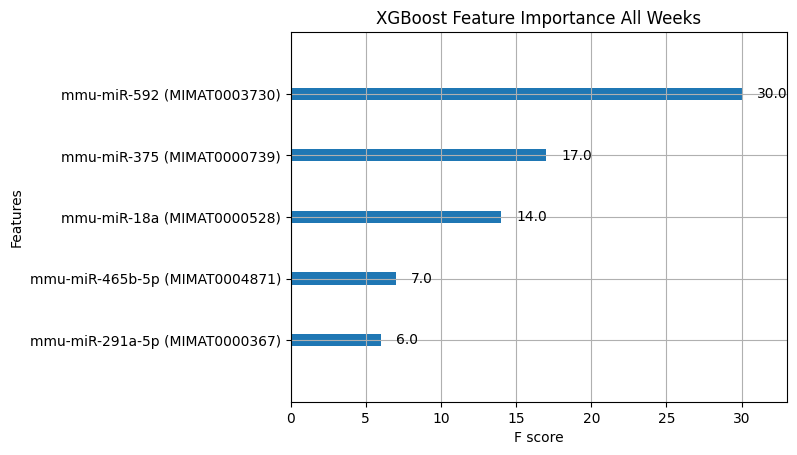

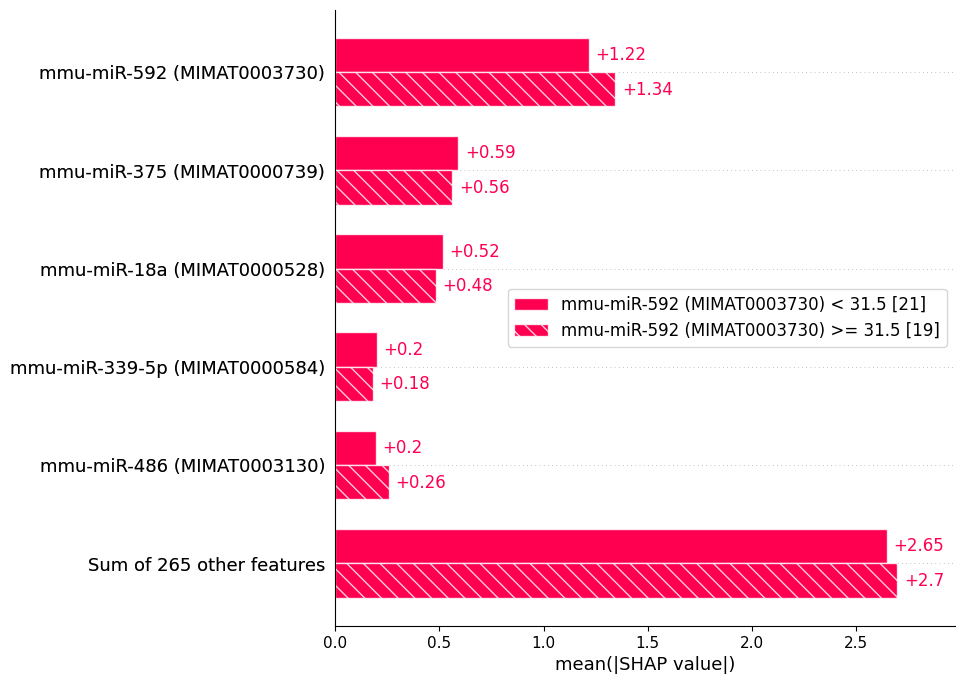

In [44]:
xgb.plot_importance(model_selected_all, max_num_features=5, title='XGBoost Feature Importance All Weeks')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_selected_all.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

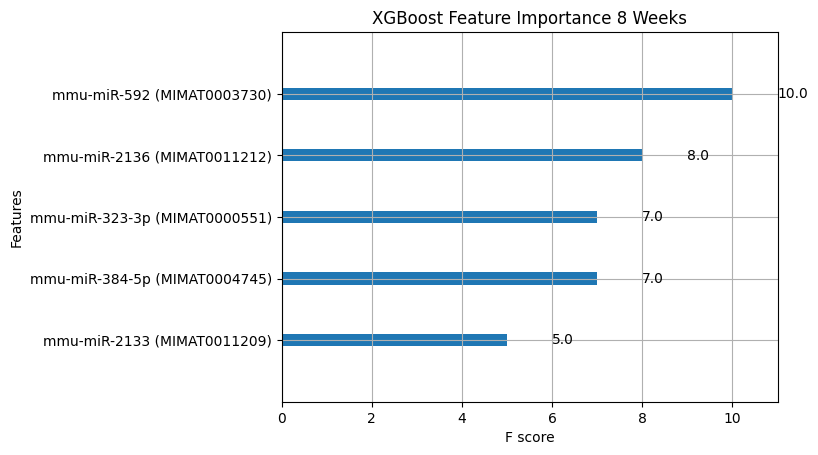

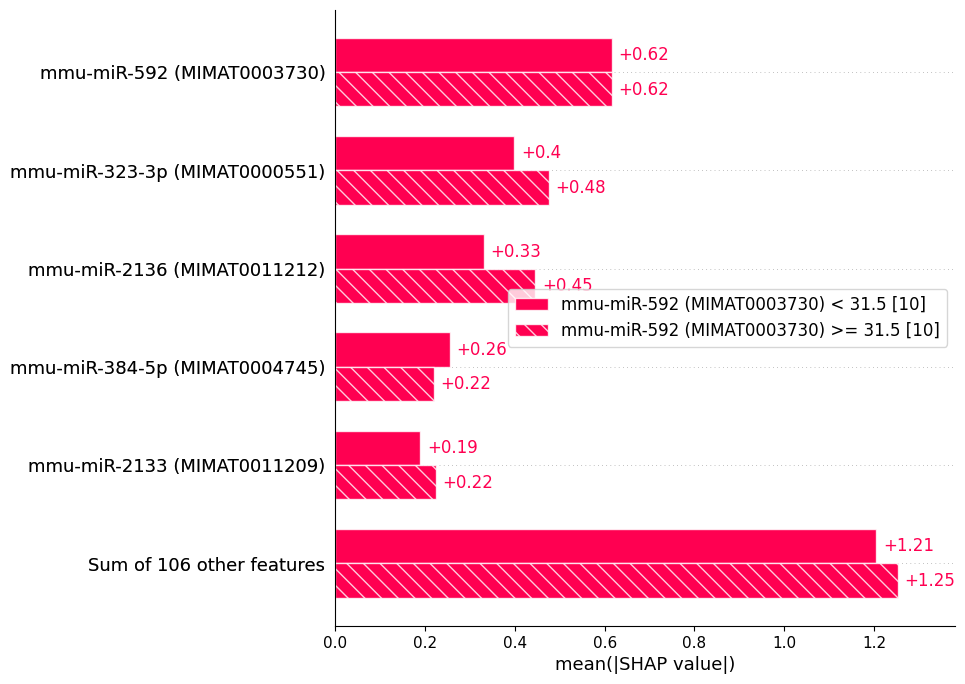

In [45]:
xgb.plot_importance(model_selected_8, max_num_features=5, title='XGBoost Feature Importance 8 Weeks')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_selected_8.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()

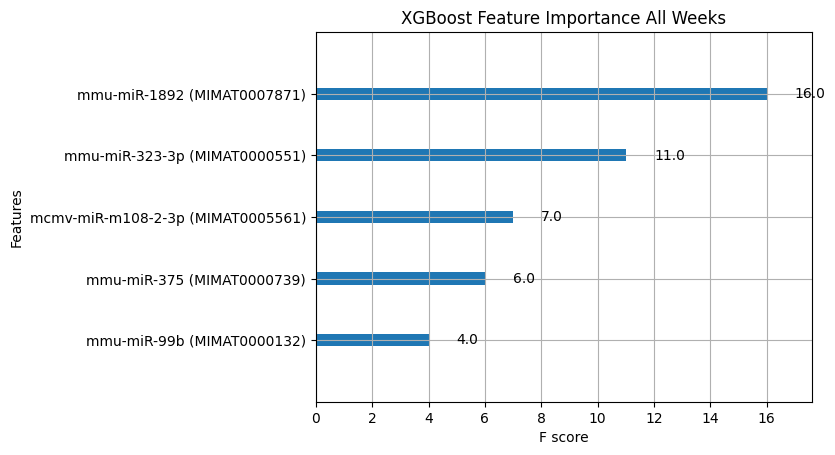

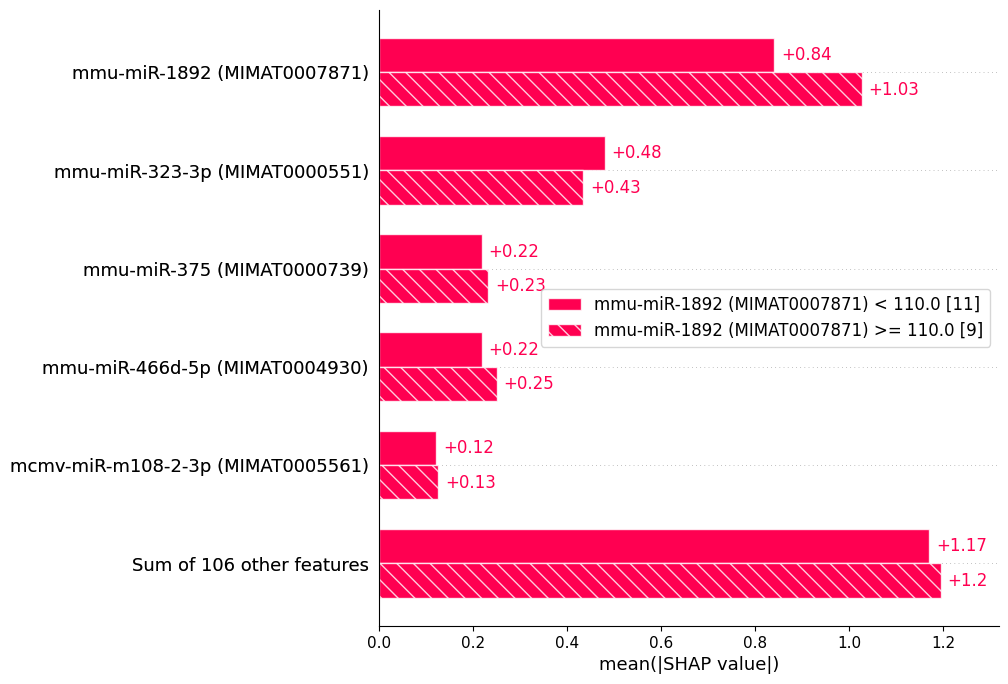

In [46]:
xgb.plot_importance(model_selected_16, max_num_features=5, title='XGBoost Feature Importance All Weeks')
plt.figure(figsize = (12, 8))

# fig = plt.figure()
shap.plots.bar(shap_values_selected_16.cohorts(2).abs.mean(0), max_display=6, show=False)
plt.gcf().set_size_inches(8,8)
plt.show()